## Setup

In [1]:
# import code
import re
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

In [2]:
# load original data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

In [2]:
# alternatively, load preprocessed data sets into dataframes
outcomes = pd.read_csv('outcomes.csv')
predictors = pd.read_csv('predictors.csv')

## Original Data Set Info & Reduction

In [3]:
# how many rows and columns in dataframe, can also use data.shape
data.info()

# to get more detail about specific range of columns
# data.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 534 entries, b_start_date to b_covid_symptoms_na
dtypes: float64(412), int64(59), object(63)
memory usage: 10.0+ MB


In [4]:
# reduce to columns of interest
# eed scale is named differently with no b_
# data = data[['b_uls_mean', 'b_cdi_mean', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
#             'b_bads_mean', 'b_shs_mean' , 'b_bhs_mean', 'b_aces_mean' , 'b_mvps_mean', 
#             'eds_events_mean', 'b_gad_mean', 'b_sitbi_2',  'b_sitbi_8', 'b_sitbi_si_month_1', 
#             'b_sitbi_nssi_month_1', 'b_sitbi_nssi_3months_1', 'b_sitbi_nssi_year_1', 
#             'b_sitbi_nssi_life_1','b_sitbi_si_3month_1', 'b_sitbi_si_year_1', 
#             'b_sitbi_si_life_1', 'b_sitbi_plan_3month_1', 'b_sitbi_plan_year_1', 
#             'b_sitbi_plan_life_1', 'b_sitbi_attempt_3months_1', 'b_sitbi_attempt_year_1', 
#             'b_sitbi_attempt_life_1', 'b_sitbi_11', 'b_sitbi_13', 'b_sitbi_16', 'b_sitbi_17', 
#             'b_sitbi_20']]

# reduced outcomes version
data = data[['b_uls_mean', 'b_cdi_mean', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_mean', 'b_shs_mean' , 'b_bhs_mean', 'b_aces_mean' , 'b_mvps_mean', 
             'eds_events_mean', 'b_gad_mean', 'b_sitbi_2',  'b_sitbi_8', 
             'b_sitbi_nssi_year_1', 'b_sitbi_si_year_1', 'b_sitbi_attempt_year_1', 'b_sitbi_17']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_uls_mean              2449 non-null   float64
 1   b_cdi_mean              2452 non-null   float64
 2   b_dem_sex               2452 non-null   object 
 3   b_dem_gender            2452 non-null   object 
 4   b_dem_orientation       2452 non-null   object 
 5   b_bads_mean             2451 non-null   float64
 6   b_shs_mean              2452 non-null   float64
 7   b_bhs_mean              2451 non-null   float64
 8   b_aces_mean             2451 non-null   float64
 9   b_mvps_mean             2450 non-null   float64
 10  eds_events_mean         2449 non-null   float64
 11  b_gad_mean              2447 non-null   float64
 12  b_sitbi_2               2451 non-null   float64
 13  b_sitbi_8               2452 non-null   int64  
 14  b_sitbi_nssi_year_1     1604 non-null   

In [7]:
# give columns more intuitive names
data.rename(columns = {'b_uls_mean':'loneliness', 'b_cdi_mean':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_mean':'behav_act',
                        'b_shs_mean':'hope', 'b_bhs_mean':'hopelessness', 'b_aces_mean':'child_adverse',
                        'b_mvps_mean':'peer_vict', 'eds_events_mean':'discrimination', 
                        'b_gad_mean':'anxiety', 'b_sitbi_2':'nssi_bin', 'b_sitbi_8':'si_bin',
                        'b_sitbi_nssi_year_1':'nssi_year', 'b_sitbi_si_year_1':'si_year',
                        'b_sitbi_attempt_year_1':'attempt_year', 'b_sitbi_17':'attempt_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2449 non-null   float64
 1   depression      2452 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2451 non-null   float64
 6   hope            2452 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2451 non-null   float64
 9   peer_vict       2450 non-null   float64
 10  discrimination  2449 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
 13  si_bin          2452 non-null   int64  
 14  nssi_year       1604 non-null   float64
 15  si_year         1955 non-null   float64
 16  attempt_year    774 non-null    float64
 17  attempt_bin     2452 non-null   i

In [8]:
# missing data counts
missing_values_count = data.isnull().sum()
missing_values_count

loneliness           3
depression           0
sex                  0
gender               0
orientation          0
behav_act            1
hope                 0
hopelessness         1
child_adverse        1
peer_vict            2
discrimination       3
anxiety              5
nssi_bin             1
si_bin               0
nssi_year          848
si_year            497
attempt_year      1678
attempt_bin          0
dtype: int64

In [9]:
# delete whole samples missing values for b_sitbi_2, b_sitbi_8, b_sitbi_13, b_sitbi_17
# these are yes/no target variables with branching logic for whether other target variables were presented
# only b_sitbi_2 has a single missing value
data = data[data['nssi_bin'].notna()]

# confirming drop of 1 sample
data.shape

(2451, 18)

In [10]:
# separate output variables
outcomes = data[['nssi_bin', 'si_bin', 'nssi_year', 'si_year', 'attempt_year', 'attempt_bin']].copy()

# replace missing values with zeros, which is appropriate for these variables
imp_zeros = SimpleImputer(strategy='constant', fill_value=0)
outcomes.iloc[:,:] = imp_zeros.fit_transform(outcomes)

# save outcomes to csv to bypass this preprocessing in the future 
outcomes.to_csv('outcomes.csv', index=False)

outcomes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2451
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nssi_bin      2451 non-null   float64
 1   si_bin        2451 non-null   float64
 2   nssi_year     2451 non-null   float64
 3   si_year       2451 non-null   float64
 4   attempt_year  2451 non-null   float64
 5   attempt_bin   2451 non-null   float64
dtypes: float64(6)
memory usage: 134.0 KB


In [11]:
# separate predictor variables
predictors = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

In [12]:
# preview predictors
predictors.head() 

,loneliness,depression,sex,gender,orientation,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
0,2.25,1.750000,Female,Woman/Girl,Heterosexual/Straight,2.888889,2.166667,2.75,0.6,0.8750,2.9,2.428571
1,1.90,1.166667,Female,Woman/Girl,Bisexual,3.555556,3.833333,1.75,0.4,0.0000,3.4,3.142857
2,1.80,0.750000,Male,Not sure,Queer,2.444444,2.833333,1.75,0.8,0.2500,3.2,2.571429
3,2.15,0.916667,Female,Woman/Girl,Heterosexual/Straight,3.111111,4.333333,1.75,0.8,0.3125,2.3,2.857143
4,1.70,0.583333,Female,Woman/Girl,Heterosexual/Straight,2.222222,3.333333,1.00,0.2,0.0000,1.6,1.571429


In [13]:
# how many unique values per feature
for c in predictors.columns:
    print(len(data[c].unique()), "unique values in column", c)

41 unique values in column loneliness
27 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
48 unique values in column behav_act
45 unique values in column hope
14 unique values in column hopelessness
9 unique values in column child_adverse
36 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety


In [14]:
# look at gender values, which need to be recoded
predictors['gender'].value_counts()

Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Tr

In [15]:
# recode gender values into 3 categories
predictors.loc[predictors['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
predictors.loc[predictors['gender'] == 'Man/Boy', 'gender'] = 'man_only'
predictors.loc[(predictors['gender'] != 'man_only') & (predictors['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [16]:
# verify recoding results
predictors['gender'].value_counts()

woman_only        1383
gender_diverse     874
man_only           194
Name: gender, dtype: int64

In [17]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2451
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2448 non-null   float64
 1   depression      2451 non-null   float64
 2   sex             2451 non-null   object 
 3   gender          2451 non-null   object 
 4   orientation     2451 non-null   object 
 5   behav_act       2450 non-null   float64
 6   hope            2451 non-null   float64
 7   hopelessness    2450 non-null   float64
 8   child_adverse   2450 non-null   float64
 9   peer_vict       2449 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2446 non-null   float64
dtypes: float64(9), object(3)
memory usage: 248.9+ KB


In [18]:
print('The percentage of missing data is: ' 
      f'{(predictors.isnull().sum().sum() * 100) / (predictors.shape[0] * predictors.shape[1])}') 

The percentage of missing data is: 0.05439956480348157


In [19]:
# create a view of the numeric predictors for imputation
numeric_predictors = predictors.select_dtypes(include=['float64'])

In [20]:
# replace missing values (very small number of missing values here) using nearest neighbors based on available features
imputer = KNNImputer(n_neighbors=5)
numeric_predictors.iloc[:,:] = imputer.fit_transform(numeric_predictors)

In [21]:
# save outcomes to csv to bypass this preprocessing in the future 
predictors.to_csv('predictors.csv', index=False)

predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2451
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2451 non-null   float64
 1   depression      2451 non-null   float64
 2   sex             2451 non-null   object 
 3   gender          2451 non-null   object 
 4   orientation     2451 non-null   object 
 5   behav_act       2451 non-null   float64
 6   hope            2451 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2451 non-null   float64
 9   peer_vict       2451 non-null   float64
 10  discrimination  2451 non-null   float64
 11  anxiety         2451 non-null   float64
dtypes: float64(9), object(3)
memory usage: 248.9+ KB


## Subset Data Set for Analysis

In [43]:
# define target variable and extract it from the data
target_column = "b_sitbi_2"
target = data[target_column]

In [44]:
# check balance of target
target.value_counts()

1.0    1653
0.0     798
Name: b_sitbi_2, dtype: int64

In [3]:
# separately extract numeric and categorical data of interest
numeric_columns = ['b_uls_mean', 'b_cdi_mean', 'b_bads_mean', 'b_shs_mean' , 'b_bhs_mean', 'b_aces_mean' , 'b_mvps_mean',
'eds_events_mean', 'b_gad_mean']
data_numeric = data[numeric_columns]
categorical_columns = ['b_dem_sex', 'b_dem_gender', 'b_dem_orientation']
data_categorical = data[categorical_columns]

In [4]:
# create data set with only variables of interest
model_data = pd.concat([data_numeric, data_categorical, target], axis=1)

In [5]:
# drop samples missing the target
model_data = model_data[model_data['b_sitbi_2'].notna()]
target = model_data[target_column]
model_data.drop(columns = [target_column])

,b_uls_mean,b_cdi_mean,b_bads_mean,b_shs_mean,b_bhs_mean,b_aces_mean,b_mvps_mean,eds_events_mean,b_gad_mean,b_dem_sex,b_dem_gender,b_dem_orientation
0,2.25,1.750000,2.888889,2.166667,2.75,0.6,0.8750,2.9,2.428571,Female,Woman/Girl,Heterosexual/Straight
1,1.90,1.166667,3.555556,3.833333,1.75,0.4,0.0000,3.4,3.142857,Female,Woman/Girl,Bisexual
2,1.80,0.750000,2.444444,2.833333,1.75,0.8,0.2500,3.2,2.571429,Male,Not sure,Queer
3,2.15,0.916667,3.111111,4.333333,1.75,0.8,0.3125,2.3,2.857143,Female,Woman/Girl,Heterosexual/Straight
4,1.70,0.583333,2.222222,3.333333,1.00,0.2,0.0000,1.6,1.571429,Female,Woman/Girl,Heterosexual/Straight
...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2.05,1.083333,3.111111,3.000000,2.25,0.4,0.5000,2.6,3.142857,Female,Other (please specify),Asexual
2448,1.95,0.666667,3.444444,4.000000,0.50,0.6,0.2500,1.0,2.285714,Female,Woman/Girl,Heterosexual/Straight
2449,1.90,1.500000,3.222222,2.000000,2.75,1.0,0.1250,2.9,3.142857,Female,"Transgender,Female to male transgender/FTM,Tra...",Unsure/Questioning
2450,2.10,1.750000,2.000000,1.833333,2.00,1.0,1.0625,3.0,3.571429,Male,Man/Boy,Bisexual


In [19]:
model_data.head()

,b_uls_mean,b_cdi_mean,b_bads_mean,b_shs_mean,b_bhs_mean,b_aces_mean,b_mvps_mean,eds_events_mean,b_gad_mean,b_dem_sex,b_dem_gender,b_dem_orientation
0,2.25,1.750000,2.888889,2.166667,2.75,0.6,0.8750,2.9,2.428571,Female,Woman/Girl,Heterosexual/Straight
1,1.90,1.166667,3.555556,3.833333,1.75,0.4,0.0000,3.4,3.142857,Female,Woman/Girl,Bisexual
2,1.80,0.750000,2.444444,2.833333,1.75,0.8,0.2500,3.2,2.571429,Male,Not sure,Queer
3,2.15,0.916667,3.111111,4.333333,1.75,0.8,0.3125,2.3,2.857143,Female,Woman/Girl,Heterosexual/Straight
4,1.70,0.583333,2.222222,3.333333,1.00,0.2,0.0000,1.6,1.571429,Female,Woman/Girl,Heterosexual/Straight


## Exploring Data Set

<AxesSubplot:xlabel='anxiety', ylabel='Count'>

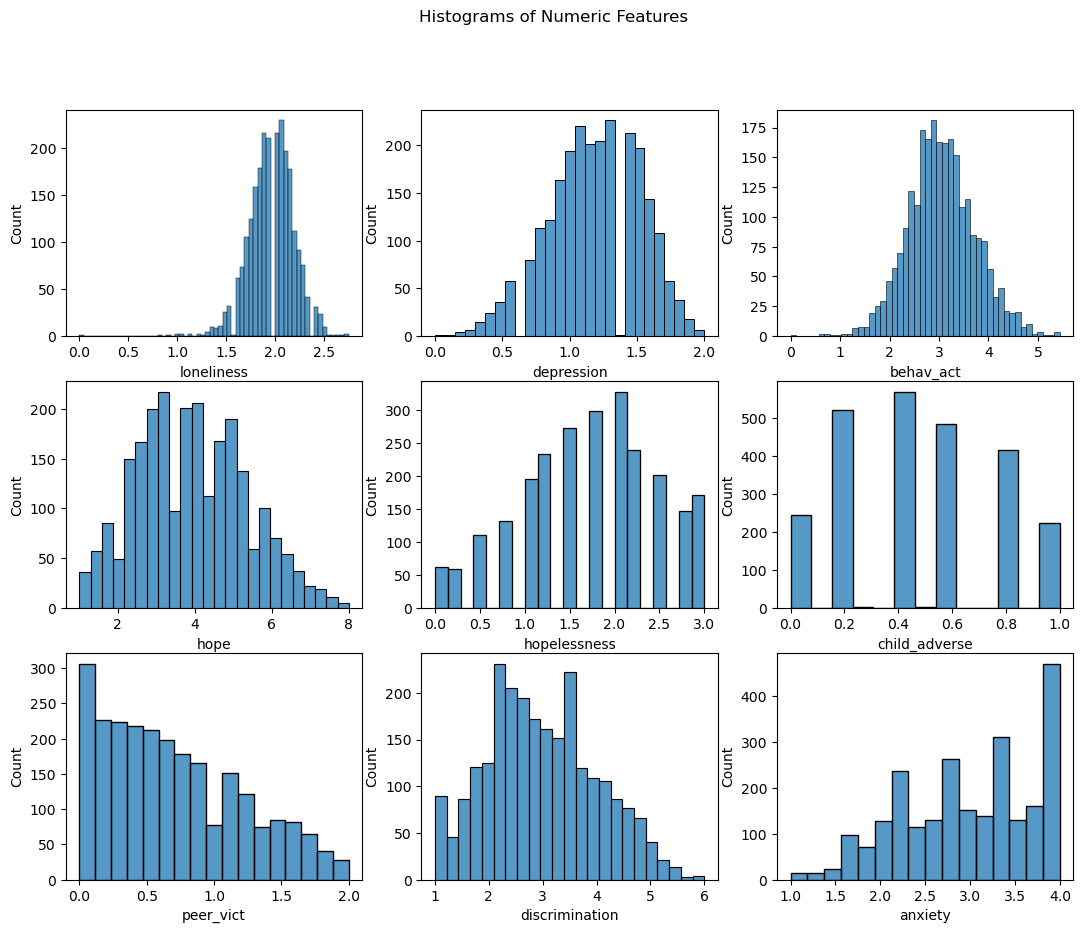

In [22]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=predictors['loneliness'])
sns.histplot(ax=axes[0, 1], data=predictors['depression'])
sns.histplot(ax=axes[0, 2], data=predictors['behav_act'])
sns.histplot(ax=axes[1, 0], data=predictors['hope'])
sns.histplot(ax=axes[1, 1], data=predictors['hopelessness'])
sns.histplot(ax=axes[1, 2], data=predictors['child_adverse'])
sns.histplot(ax=axes[2, 0], data=predictors['peer_vict'])
sns.histplot(ax=axes[2, 1], data=predictors['discrimination'])
sns.histplot(ax=axes[2, 2], data=predictors['anxiety'])

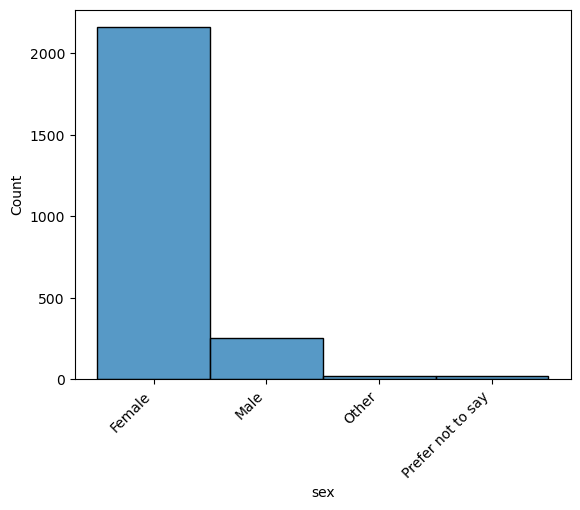

In [23]:
# countplots of categorical features
sns.histplot(predictors['sex'])
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)

# don't show the label objects
None

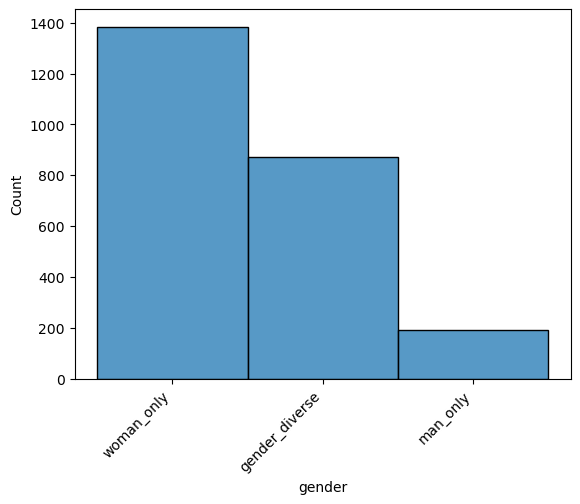

In [24]:
sns.histplot(predictors['gender'])
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
None

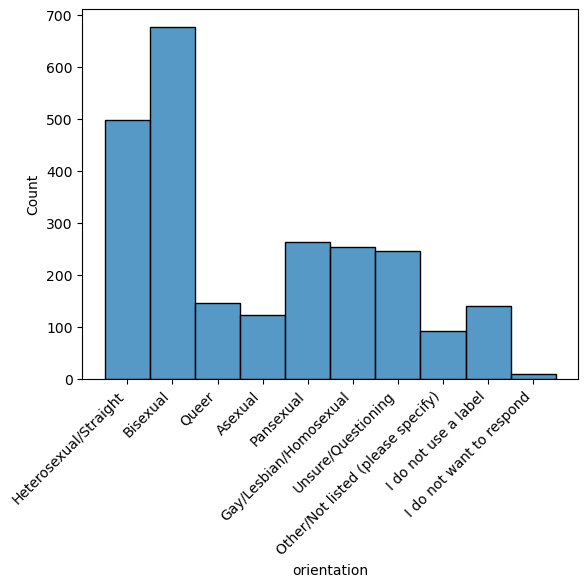

In [25]:
sns.histplot(predictors['orientation'])
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
None

In [47]:
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2452 entries, 0 to 2451
Series name: b_sitbi_2
Non-Null Count  Dtype  
--------------  -----  
2451 non-null   float64
dtypes: float64(1)
memory usage: 19.3 KB


Text(0.5, 0.98, 'b_sitbi_2 counts')

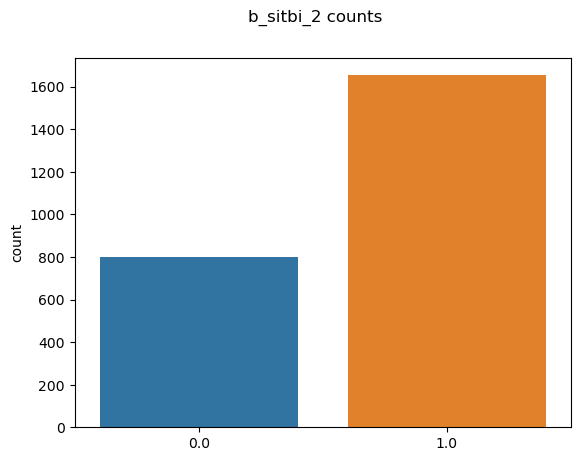

In [53]:
# countplot of target
sns.countplot(data=target, x=target.values)
plt.suptitle('b_sitbi_2 counts')

In [51]:
# target category percentages
target.value_counts(normalize=True)*100

1.0    67.44186
0.0    32.55814
Name: b_sitbi_2, dtype: float64

## Initial Random Forest Model

In [14]:
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

imputer = KNNImputer()

RFC = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=0)

model = make_pipeline(preprocessor, imputer, RFC)

In [15]:
# model is actually run 
cv_results = cross_validate(model, model_data, target)

In [11]:
print("The mean accuracy with cross-validation is: " 
      f"{cv_results['test_score'].mean():.3f} +/- {cv_results['test_score'].std():.3f}") 

The mean accuracy with cross-validation is: 0.713 +/- 0.006


In [17]:
#identify which target value is most common in the SI target variable and see how accurate it is
dummy_results = cross_validate(DummyClassifier(), model_data, target)
print("The mean accuracy with cross-validation is: " 
      f"{dummy_results['test_score'].mean():.3f} +/- {dummy_results['test_score'].std():.3f}") 

The mean accuracy with cross-validation is: 0.674 +/- 0.001


## Some code for random forest classifier for later

### Optimizing model parameters

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [ ]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
#Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. 
#I took the best model from this and did a more granular search 
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

In [ ]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

In [ ]:
import matplotlib.pyplot as plt
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')